In [1]:
"""
This notebook generates the frequency and prom:enhD ratio plots in for TF-MoDISco quantity (Fig. 2C).
For example track and DeepSHAP plots, please see the example tracks directory.
"""

'\nThis notebook generates the frequency and prom:enhD ratio plots in for TF-MoDISco quantity (Fig. 2C).\nFor example track and DeepSHAP plots, please see the example tracks directory.\n'

In [2]:
import numpy as np
import h5py
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
from matplotlib import colors
from pathlib import Path
import pybedtools

In [3]:
# PRINT COMMANDS TO DOWNLOAD AND EXTRACT DATA

# Set scratch to where you want to download data to
SCRATCH = "/Users/adamhe/github/scratch"

URL = "https://zenodo.org/records/10597358/files"
TAR = "tfmodisco_results.tar.gz"
print(f"wget {URL}/{TAR} -P {SCRATCH}")
print(f"tar -xvzf {SCRATCH}/{TAR}")

# Download cCRE data from ENCODE:

print(f"wget https://downloads.wenglab.org/cCREs/GRCh38-PLS.bed -P {SCRATCH}")
print(f"wget https://downloads.wenglab.org/cCREs/GRCh38-ELS.bed -P {SCRATCH}")

wget https://zenodo.org/records/10597358/files/tfmodisco_results.tar.gz -P /Users/adamhe/github/scratch
tar -xvzf /Users/adamhe/github/scratch/tfmodisco_results.tar.gz
wget https://downloads.wenglab.org/cCREs/GRCh38-PLS.bed -P /Users/adamhe/github/scratch
wget https://downloads.wenglab.org/cCREs/GRCh38-ELS.bed -P /Users/adamhe/github/scratch


In [4]:
# LOAD DATA

# Get promoter and enhancer
prom_bed = pybedtools.BedTool(Path(SCRATCH, "GRCh38-PLS.bed"))
enh_bed = pybedtools.BedTool(Path(SCRATCH, "GRCh38-ELS.bed"))
# Read in windows around PRO-cap peaks in LCLs
all_bed = pybedtools.BedTool(Path(SCRATCH, "tfmodisco_results/merged_windows_all.bed.gz"))
# Filter ENCODE cCREs for those active in LCLs
active_prom_bed = prom_bed.intersect(all_bed, u=True)
active_enh_bed = enh_bed.intersect(all_bed, u=True)
# Load the modisco results
modisco = h5py.File(
    os.path.join(SCRATCH, "tfmodisco_results/mean_across_folds_all_quantity_modisco.h5"), "r"
)

In [40]:
# Manually annotate modisco hits by likely motif

motifs = [
    "ETS",
    "SP/KLF",
    "NFY",
    "NRF1",
    "YY1/2",
    "CREB",
    "Inr (CA)",
    "IRF",
    "CpG",
    "CTCF",
    "Inr (CA)",
    "Arntl",
    "CpG",
    "CpG",
    "THAP",
    "CpG",
    "TBP",
    "ZBTB33",
    "NRF1",
    "CpG",
    "CpG",
    "CpG",
    "POU",
    "CpG",
    "CpG",
    "CpG",
    "CpG",
    "TBP",
    "SPIB",
    "TBP",
    "SP/KLF",
    "ZNF76",
    "CpG",
    "Inr (CA)",
    "THAP",
    "JUNB",
    "ETS",
    "SP/KLF::ETS",
    "Inr (CA)",
    "CREB",
    "SP/KLF",
    "IRF",
    "TBP",
    "IRF",
    "NFKB2",
    "CTCF",
    "NRF1",
    "ZBTB33",
    "???",
    "Inr (CA)",
    "CREB",
    "ETS"
]

In [41]:
# Get counts per motif (w/ and w/o counting multiplicity per element)

modisco_n = len(modisco["pos_patterns"])
outdir = Path(SCRATCH, "uniq_coords")

motif_counts = pd.DataFrame(
    [
        pd.read_csv(
            outdir.joinpath(f"modisco_quantity_pattern_{i}_coords.txt.gz"), sep="\t"
        ).shape[0] for i in range(modisco_n)
    ]
)
motif_coords = [
    pd.read_csv(
        outdir.joinpath(f"modisco_quantity_pattern_{i}_coords.txt.gz"), sep="\t", index_col=0
    ) for i in range(modisco_n)
]
motif_beds = [
    pybedtools.BedTool.from_dataframe(motif_coords[i]) for i in range(modisco_n)
]

In [51]:
# Get motif counts
 
motif_counts.index = motifs
grouped_motifs = motif_counts.groupby(motifs).sum()
grouped_motifs.sort_values(0, ascending=False, inplace=True)
grouped_motifs.columns = ["total"]

# Get motif counts in promoters and enhancers

prom_motif_counts = pd.DataFrame(
    [
        len(active_prom_bed.intersect(motif_beds[i])) for i in range(modisco_n)
    ]
)
prom_motif_counts.index = motifs
grouped_prom_motifs = prom_motif_counts.groupby(motifs).sum()

enh_motif_counts = pd.DataFrame(
    [
        len(active_enh_bed.intersect(motif_beds[i])) for i in range(modisco_n)
    ]
)
enh_motif_counts.index = motifs
grouped_enh_motifs = enh_motif_counts.groupby(motifs).sum()

grouped_motifs["prom"] = grouped_prom_motifs / len(active_prom_bed)
grouped_motifs["enh"] = grouped_enh_motifs / len(active_enh_bed)
grouped_motifs.drop(["???", "CpG"], inplace=True)

In [43]:
pd.DataFrame(grouped_motifs["total"])[:-4].shape

(17, 1)

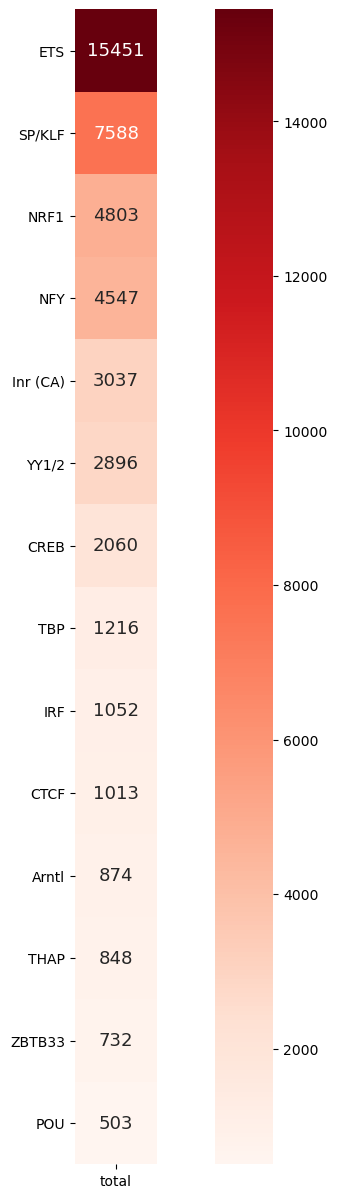

In [55]:
# Plot motif frequency

fig = plt.figure(figsize=(15, 15))
sns.heatmap(
    pd.DataFrame(grouped_motifs["total"])[:14],
    annot=True,
    annot_kws={"size": 13},
    cmap="Reds",
    fmt="g",
    square=True,
    #cbar=False,
    #norm=colors.TwoSlopeNorm(0)
)
plt.yticks(rotation=0) 
plt.savefig("img/modisco_quantity_frequency_plot.pdf")

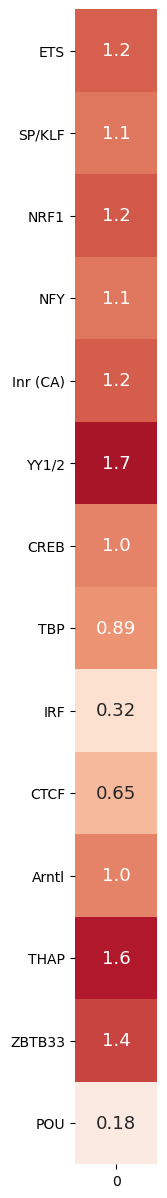

In [54]:
# Plot log10(prom/enhD)

fig = plt.figure(figsize=(15, 15))
sns.heatmap(
    pd.DataFrame(np.log2(grouped_motifs["prom"] / grouped_motifs["enh"]))[:14],
    annot=True,
    annot_kws={"size": 13},
    fmt=".2",
    square=True,
    cbar=False,
    cmap="RdBu_r",
    norm=colors.Normalize(-2, 2)
)
plt.yticks(rotation=0) 
plt.savefig("img/modisco_quantity_prom2enh_plot.pdf")